In [69]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import warnings
import os
warnings.filterwarnings('ignore')

In [45]:
train_df = pd.read_csv('data/train.csv')

In [46]:
train_df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [47]:
#check for any nulll values
train_df.isnull().any().any()

False

In [48]:
#check for any height and width is other than 1024
print((train_df['height']!=1024).any())
print((train_df['width']!=1024).any())

False
False


In [49]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147793 entries, 0 to 147792
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   image_id  147793 non-null  object
 1   width     147793 non-null  int64 
 2   height    147793 non-null  int64 
 3   bbox      147793 non-null  object
 4   source    147793 non-null  object
dtypes: int64(2), object(3)
memory usage: 5.6+ MB


In [65]:
img_bb = train_df[['image_id','bbox']]

In [66]:
img_bb['bbox'] = img_bb['bbox'].str.strip('][').str.split(',')
img_bb.head()

,image_id,bbox
0,b6ab77fd7,"[834.0, 222.0, 56.0, 36.0]"
1,b6ab77fd7,"[226.0, 548.0, 130.0, 58.0]"
2,b6ab77fd7,"[377.0, 504.0, 74.0, 160.0]"
3,b6ab77fd7,"[834.0, 95.0, 109.0, 107.0]"
4,b6ab77fd7,"[26.0, 144.0, 124.0, 117.0]"


In [67]:
img_bb['x'] =''
img_bb['y'] =''
img_bb['w'] =''
img_bb['h'] =''
img_bb['xy_min'] = ''
img_bb['xy_max'] = ''
img_bb.head()

,image_id,bbox,x,y,w,h,xy_min,xy_max
0,b6ab77fd7,"[834.0, 222.0, 56.0, 36.0]",,,,,,
1,b6ab77fd7,"[226.0, 548.0, 130.0, 58.0]",,,,,,
2,b6ab77fd7,"[377.0, 504.0, 74.0, 160.0]",,,,,,
3,b6ab77fd7,"[834.0, 95.0, 109.0, 107.0]",,,,,,
4,b6ab77fd7,"[26.0, 144.0, 124.0, 117.0]",,,,,,


In [68]:
for i in range(len(img_bb)):
    img_bb.iloc[i,1] = pd.to_numeric(img_bb.iloc[i,1],downcast='integer')
    img_bb.loc[i,'x'] = img_bb.loc[i,'bbox'][0]
    img_bb.loc[i,'y'] = img_bb.loc[i,'bbox'][1]
    img_bb.loc[i,'w'] = img_bb.loc[i,'bbox'][2]
    img_bb.loc[i,'h'] = img_bb.loc[i,'bbox'][3]
    img_bb.loc[i,'xy_min'] = (int(img_bb.loc[i,'x']),int(img_bb.loc[i,'y']))
    img_bb.loc[i,'xy_max']= (int(img_bb.loc[i,'x'] + img_bb.loc[i,'w']),int(img_bb.loc[i,'y'] + img_bb.loc[i,'h']))
    if i%3000==0:
        print('iter: ',i)

iter:  0
iter:  3000
iter:  6000
iter:  9000
iter:  12000
iter:  15000
iter:  18000
iter:  21000
iter:  24000
iter:  27000
iter:  30000
iter:  33000
iter:  36000
iter:  39000
iter:  42000
iter:  45000
iter:  48000
iter:  51000
iter:  54000
iter:  57000
iter:  60000
iter:  63000
iter:  66000
iter:  69000
iter:  72000
iter:  75000
iter:  78000
iter:  81000
iter:  84000
iter:  87000
iter:  90000
iter:  93000
iter:  96000
iter:  99000
iter:  102000
iter:  105000
iter:  108000
iter:  111000
iter:  114000
iter:  117000
iter:  120000
iter:  123000
iter:  126000
iter:  129000
iter:  132000
iter:  135000
iter:  138000
iter:  141000
iter:  144000
iter:  147000


In [70]:
img_bb.head()


,image_id,bbox,x,y,w,h,xy_min,xy_max
0,b6ab77fd7,"[834, 222, 56, 36]",834,222,56,36,"(834, 222)","(890, 258)"
1,b6ab77fd7,"[226, 548, 130, 58]",226,548,130,58,"(226, 548)","(356, 606)"
2,b6ab77fd7,"[377, 504, 74, 160]",377,504,74,160,"(377, 504)","(451, 664)"
3,b6ab77fd7,"[834, 95, 109, 107]",834,95,109,107,"(834, 95)","(943, 202)"
4,b6ab77fd7,"[26, 144, 124, 117]",26,144,124,117,"(26, 144)","(150, 261)"


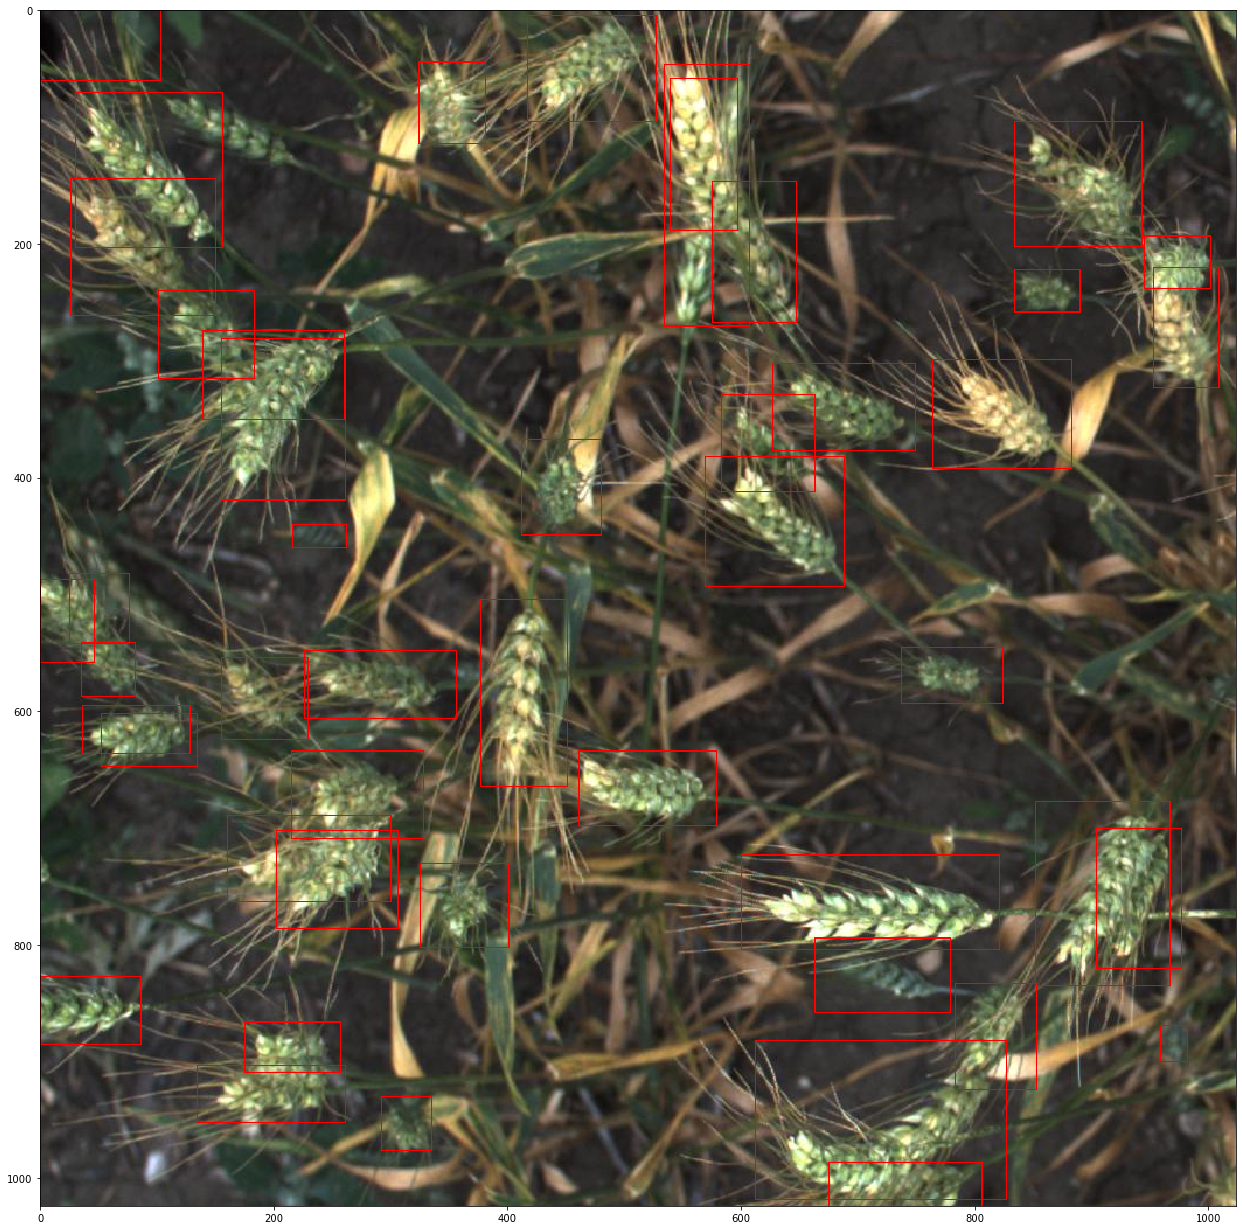

In [77]:
#checking bounding box with one image
check_img_id = img_bb.loc[0,'image_id']
img = cv2.imread('data/train/' + check_img_id +'.jpg')
rgb_img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
for i in range(len(img_bb[img_bb['image_id']== check_img_id])):
    
    rec = cv2.rectangle(rgb_img,img_bb.loc[i,'xy_min'],img_bb.loc[i,'xy_max'],(255,0,0),1,1)
plt.figure(figsize=(22,22))
plt.imshow(rgb_img)

# Converting into yolo label

In [78]:
image_id_list = train_df['image_id'].unique()

In [79]:
len(image_id_list)

3373

In [80]:
train_dir_images_list=os.listdir('data/train/')

In [81]:
print('images without label: {}'.format(len(train_dir_images_list)-len(image_id_list)))

images without label: 49


## Making blank .txt file for all images

In [87]:
#becuase 49 images dont have labels and it will cuase error while training  
for img in train_dir_images_list:
    f  = open("data/labels/"+ img[:-4] + ".txt", "w")
    f.close()

## Now loop though fill .txt file with labels

In [99]:
label = pd.DataFrame()

In [100]:
for j , id in enumerate(image_id_list):
    temp_df = train_df[train_df['image_id']== id][['image_id','bbox']]
    temp_df['bbox'] = temp_df['bbox'].str.strip('][').str.split(',')
    temp_df['x_min'] =''
    temp_df['y_min'] =''
    temp_df['w'] =''
    temp_df['h'] =''
    temp_df['x_center'] = ''
    temp_df['y_center'] = ''
    temp_df['yolo_w'] =''
    temp_df['yolo_h'] =''
    f  = open("data/labels/"+ id + ".txt", "w+")
    for i in temp_df.index:
        temp_df.loc[i,'bbox'] = pd.to_numeric(temp_df.loc[i,'bbox'],downcast='integer')
        temp_df.loc[i,'x_min'] = temp_df.loc[i,'bbox'][0]
        temp_df.loc[i,'y_min'] = temp_df.loc[i,'bbox'][1]
        temp_df.loc[i,'w'] = temp_df.loc[i,'bbox'][2]
        temp_df.loc[i,'h'] = temp_df.loc[i,'bbox'][3]
        temp_df.loc[i,'x_center'] = np.round((temp_df.loc[i,'x_min'] + int(temp_df.loc[i,'w']/2))/1024,6)
        temp_df.loc[i,'y_center'] = np.round((temp_df.loc[i,'y_min'] + int(temp_df.loc[i,'h']/2))/1024,6)
        temp_df.loc[i,'yolo_w'] = np.round(temp_df.loc[i,'w']/1024,6)
        temp_df.loc[i,'yolo_h'] = np.round(temp_df.loc[i,'h']/1024,6)
        f.write(str(0)+' '+str(temp_df.loc[i,'x_center'])+' ' +str(temp_df.loc[i,'y_center'])+' '+str(temp_df.loc[i,'yolo_w'])+' '+str(temp_df.loc[i,'yolo_h'])+'\n')
    
    f.close()
     
    label = label.append(temp_df)
    

In [98]:
label.head()

,image_id,bbox,x_min,y_min,w,h,x_center,y_center,yolo_w,yolo_h
0,b6ab77fd7,"[834, 222, 56, 36]",834,222,56,36,0.841797,0.234375,0.054688,0.035156
1,b6ab77fd7,"[226, 548, 130, 58]",226,548,130,58,0.28418,0.563477,0.126953,0.056641
2,b6ab77fd7,"[377, 504, 74, 160]",377,504,74,160,0.404297,0.570312,0.072266,0.15625
3,b6ab77fd7,"[834, 95, 109, 107]",834,95,109,107,0.867188,0.144531,0.106445,0.104492
4,b6ab77fd7,"[26, 144, 124, 117]",26,144,124,117,0.085938,0.197266,0.121094,0.114258
